In [1]:
%reload_ext autoreload
%autoreload 2

The following example was taken from Reddy (2005) "An introduction to non-linear finite element analysis" Section 9.4.5.

Here we present numerical results obtained for a cantilevered rectangular plate of length a = 10 in, height b = 1 in, and thickness h = 0:1 in, and subjected to uniformly distributed in-plane load ty = -q0 psi, acting downward, along its length. The material of the plate has a modulus ofE = 1.2E7 psi and Poisson's ratio of nu = 0.3.

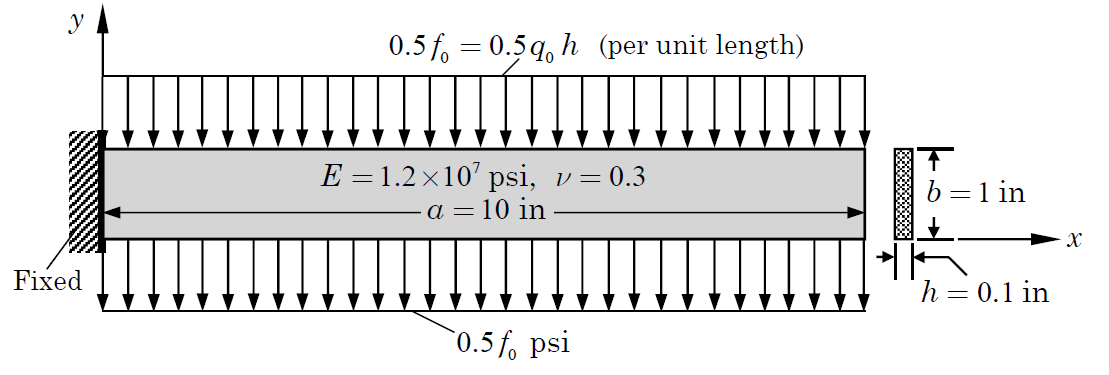

### General Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt

### Mesh definition

In [3]:
from mesh_utils import UniformQuadMesh2D

lx = 10                 # Dimension along x-coord
ly = 1                  # Dimension along y-coord
nx = 5                  # Number of elements along x-coord
ny = 1                  # Number of elements along y-coord
element_type = 'Q8'     # Type of elements

cantilever_mesh = UniformQuadMesh2D(lx, ly, nx, ny, element_type=element_type)
cantilever_mesh.compute()


In [4]:
print(f'\nNodal coordinates:\n {cantilever_mesh.coordinates}')
print(f'\nElement connectivity:\n {cantilever_mesh.elements}')

print(f'\nNumber of nodes: {cantilever_mesh.nnod}')
print(f'Number of elements: {cantilever_mesh.nelem}')


Nodal coordinates:
 [[ 0.   0. ]
 [ 1.   0. ]
 [ 2.   0. ]
 [ 3.   0. ]
 [ 4.   0. ]
 [ 5.   0. ]
 [ 6.   0. ]
 [ 7.   0. ]
 [ 8.   0. ]
 [ 9.   0. ]
 [10.   0. ]
 [ 0.   0.5]
 [ 2.   0.5]
 [ 4.   0.5]
 [ 6.   0.5]
 [ 8.   0.5]
 [10.   0.5]
 [ 0.   1. ]
 [ 1.   1. ]
 [ 2.   1. ]
 [ 3.   1. ]
 [ 4.   1. ]
 [ 5.   1. ]
 [ 6.   1. ]
 [ 7.   1. ]
 [ 8.   1. ]
 [ 9.   1. ]
 [10.   1. ]]

Element connectivity:
 {'quad': [array([20, 18,  1,  3, 19, 12,  2, 13]), array([22, 20,  3,  5, 21, 13,  4, 14]), array([24, 22,  5,  7, 23, 14,  6, 15]), array([26, 24,  7,  9, 25, 15,  8, 16]), array([28, 26,  9, 11, 27, 16, 10, 17])]}

Number of nodes: 28
Number of elements: 5


In [5]:
cantilever_mesh.node_groups

{'all': [1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28],
 'bottom': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 'top': [18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28],
 'left': [1, 12, 18],
 'right': [11, 17, 28]}

In [6]:
cantilever_mesh.element_groups

{'all': [1, 2, 3, 4, 5],
 'bottom': [1, 2, 3, 4, 5],
 'top': [1, 2, 3, 4, 5],
 'left': [1],
 'right': [5]}

### Dirichlet boundary conditions

In [7]:
from feinn_solver import BoundaryCondition

cantilever_bc = {
                'left': [BoundaryCondition(dof=1, value=0.0),
                        BoundaryCondition(dof=2, value=0.0)]
                }

### Define material

In [8]:
from matmodels import LinearElasticPlaneStress

dummy_mat = LinearElasticPlaneStress(EMOD = 1.2*1e7, nu = 0.20)

cantilever_matfld = {'all': dummy_mat}

### von Neumman boundary conditions

In [9]:
from feinn_solver import EdgeLoad

cantilever_edge_loads = {
                        'top': EdgeLoad(side = 1, ftangential = 0.0, fnormal = -4.50, reference = "global"),
                        'bottom': EdgeLoad(side = 3, ftangential = 0.0, fnormal = -4.50, reference = "global"),
                        }

### Model

In [10]:
from feinn_solver import NFEA

cantilever_fem = NFEA(mesh = cantilever_mesh, 
                      bcs = cantilever_bc, 
                      matfld = cantilever_matfld,
                      edge_loads = cantilever_edge_loads,
                      verbose = True
                      )

[matfld] Assigned: ['all']
[matfld] All 5 elements have assigned material
[edge_load] Applied 2 edge load groups
[BC] Processed 2 Dirichlet condition(s) → 6 total constraint(s)
[BC] Applied Dirichlet BCs → 6 fixed DOFs


In [11]:
# assign thickness to elements
for elem_i in cantilever_fem.elements:
    elem_i.thickness = 0.1

In [12]:
cantilever_fem.Fext_total

tensor([ 0.0000, -1.5000,  0.0000, -6.0000,  0.0000, -3.0000,  0.0000, -6.0000,
         0.0000, -3.0000,  0.0000, -6.0000,  0.0000, -3.0000,  0.0000, -6.0000,
         0.0000, -3.0000,  0.0000, -6.0000,  0.0000, -1.5000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000, -1.5000,  0.0000, -6.0000,  0.0000, -3.0000,
         0.0000, -6.0000,  0.0000, -3.0000,  0.0000, -6.0000,  0.0000, -3.0000,
         0.0000, -6.0000,  0.0000, -3.0000,  0.0000, -6.0000,  0.0000, -1.5000])

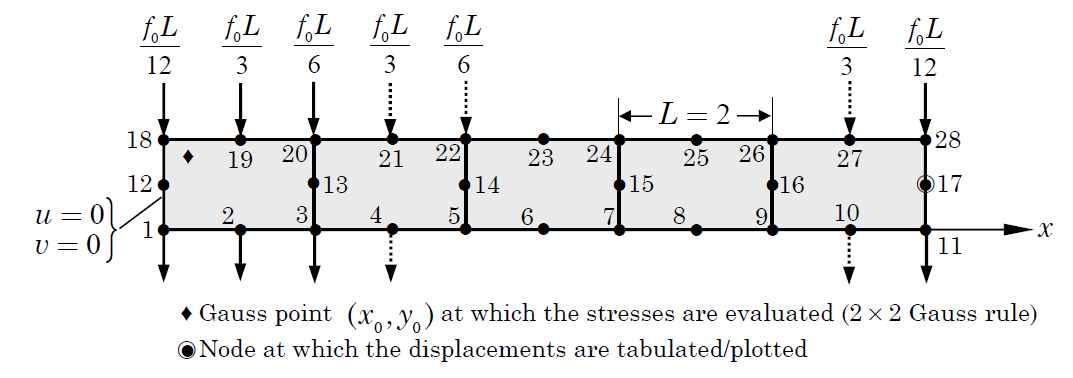

In [13]:
cantilever_fem.formulation = 'infinitesimal'
cantilever_fem.run_complete(nsteps=1)

[Load] Set load factor = 1.0000.
Iter   1 | du error: 1.00e+00  Res error: 9.64e-12  Energetic error: -8.82e-12
Iter   2 | du error: 2.20e-12  Res error: 4.79e-12  Energetic error: -3.08e-27
Converged in 2 iterations


In [14]:
cantilever_fem.udisp

tensor([ 0.0000e+00,  0.0000e+00, -1.9294e-03, -2.1783e-03, -3.5951e-03,
        -7.9336e-03, -4.8396e-03, -1.6522e-02, -5.8343e-03, -2.7332e-02,
        -6.4867e-03, -3.9776e-02, -6.9716e-03, -5.3338e-02, -7.2346e-03,
        -6.7620e-02, -7.3946e-03, -8.2306e-02, -7.4423e-03, -9.7174e-02,
        -7.4562e-03, -1.1209e-01,  0.0000e+00,  0.0000e+00,  2.2180e-20,
        -7.8318e-03, -1.7638e-19, -2.7299e-02, -1.1820e-19, -5.3318e-02,
        -1.7979e-18, -8.2301e-02, -2.2873e-18, -1.1209e-01,  0.0000e+00,
         0.0000e+00,  1.9294e-03, -2.1783e-03,  3.5951e-03, -7.9336e-03,
         4.8396e-03, -1.6522e-02,  5.8343e-03, -2.7332e-02,  6.4867e-03,
        -3.9776e-02,  6.9716e-03, -5.3338e-02,  7.2346e-03, -6.7620e-02,
         7.3946e-03, -8.2306e-02,  7.4423e-03, -9.7174e-02,  7.4562e-03,
        -1.1209e-01])

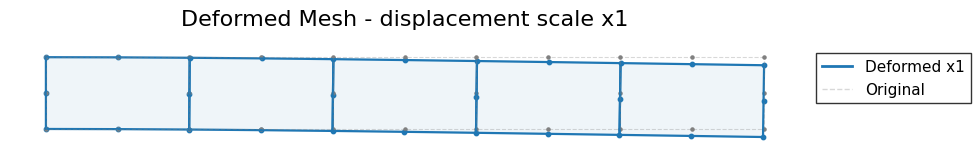

In [15]:
cantilever_fem.plot_deformed_mesh(scale=1)

In [16]:
Fint_fem = cantilever_fem._assemble_internal_forces(cantilever_fem.udisp)
Fint_fem

tensor([ 4.5000e+02,  2.1871e+02, -8.6386e-14, -6.0000e+00,  1.3074e-12,
        -3.0000e+00, -1.2940e-12, -6.0000e+00,  6.5370e-13, -3.0000e+00,
        -1.7657e-12, -6.0000e+00, -3.8369e-13, -3.0000e+00, -1.6022e-12,
        -6.0000e+00,  5.7874e-12, -3.0000e+00, -5.6892e-13, -6.0000e+00,
        -6.2279e-12, -1.5000e+00,  2.4374e-13, -3.5042e+02, -1.0764e-12,
         1.2676e-11,  1.0467e-12,  2.6501e-11, -5.4014e-12,  3.7979e-11,
        -6.3346e-12,  9.5906e-12,  4.8837e-12, -5.5719e-11, -4.5000e+02,
         2.1871e+02,  1.5922e-13, -6.0000e+00,  7.9581e-13, -3.0000e+00,
        -1.9856e-13, -6.0000e+00,  1.9895e-13, -3.0000e+00, -1.0045e-12,
        -6.0000e+00,  6.9065e-12, -3.0000e+00, -4.2475e-13, -6.0000e+00,
         1.5632e-13, -3.0000e+00,  2.3077e-12, -6.0000e+00,  2.0694e-12,
        -1.5000e+00])

In [17]:
from feinn_solver import FEINN
from nn_models import mFCNet

feinn_solver = FEINN(
    mesh=cantilever_mesh,
    bcs=cantilever_bc,
    matfld=cantilever_matfld,
    edge_loads=cantilever_edge_loads,
    verbose=False,
    nnet = mFCNet(num_layers = 12, num_neurons = 128, bias = False),
    bc_weight=1e4,
    force_scaler = 1e-6,
    nnet_init = 'xavier',
    )

# assign thickness to elements
for elem_i in feinn_solver.elements:
    elem_i.thickness = 0.1

In [18]:
from types import SimpleNamespace

cfg = SimpleNamespace(**{})

cfg.epochs = 1
cfg.learning_rate = 1e-2
cfg.lr_min = 1e-5

In [19]:
import torch

optimizer = torch.optim.Adam(
    feinn_solver.nnet.parameters(),
    lr = cfg.learning_rate,
    weight_decay = 0,
  )

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max = cfg.epochs,
    eta_min = cfg.lr_min
  )

# Entrenar
feinn_solver.train(epochs=cfg.epochs, 
                   optimizer=optimizer, 
                   scheduler=scheduler,
                   lbfgs_epochs=1000, 
                   verbose=True)

[FEINN] Starting warmup for zero initial displacement
[FEINN] Warmup completado - salida inicial ≈ 0
[FEINN] Zero-output init: max |u| inicial = 1.22e-01

Epoch 1/1
Total Loss: 4.235e+00
  Domain: 7.000e-02
  BC:     4.165e+00

Epoch 1/1000 (L-BFGS)
Total Loss: 1.293e+04
  Domain: 4.990e-02
  BC:     3.360e-05

Epoch 50/1000 (L-BFGS)
Total Loss: 1.006e-04
  Domain: 1.006e-04
  BC:     8.020e-09

Epoch 100/1000 (L-BFGS)
Total Loss: 1.006e-04
  Domain: 1.006e-04
  BC:     8.020e-09

Epoch 150/1000 (L-BFGS)
Total Loss: 1.006e-04
  Domain: 1.006e-04
  BC:     8.020e-09

Epoch 200/1000 (L-BFGS)
Total Loss: 1.006e-04
  Domain: 1.006e-04
  BC:     8.020e-09

Epoch 250/1000 (L-BFGS)
Total Loss: 1.006e-04
  Domain: 1.006e-04
  BC:     8.020e-09

Epoch 300/1000 (L-BFGS)
Total Loss: 1.006e-04
  Domain: 1.006e-04
  BC:     8.020e-09

Epoch 350/1000 (L-BFGS)
Total Loss: 1.006e-04
  Domain: 1.006e-04
  BC:     8.020e-09

Epoch 400/1000 (L-BFGS)
Total Loss: 1.006e-04
  Domain: 1.006e-04
  BC:     8.0

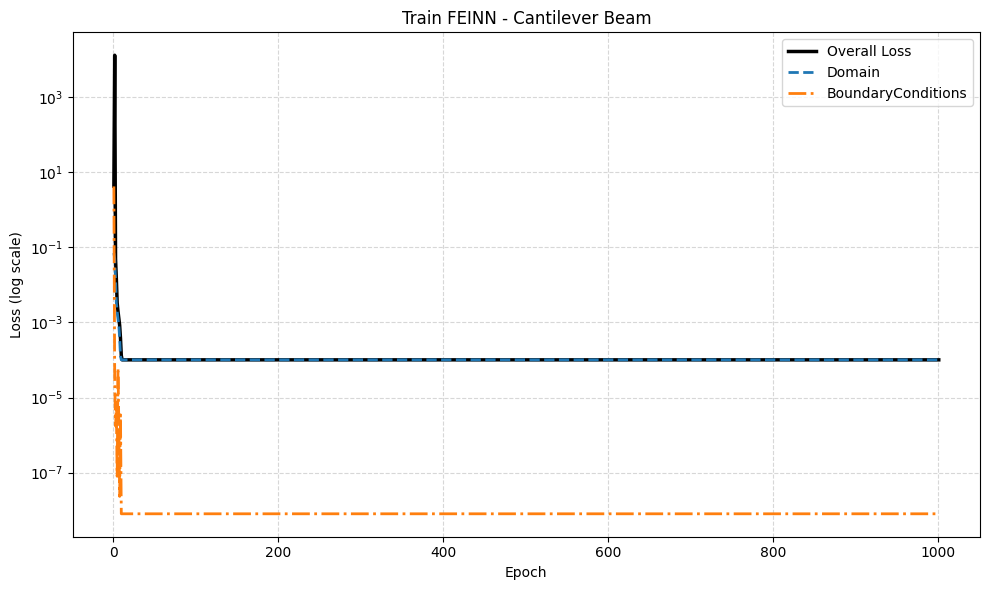

In [20]:
feinn_solver.plot_history(title="Train FEINN - Cantilever Beam")

In [21]:
feinn_solver.udisp

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])

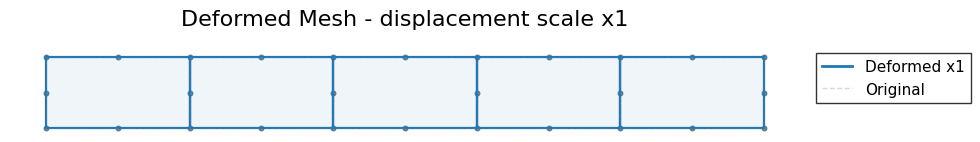

In [22]:
feinn_solver.plot_deformed_mesh(scale=1)

In [23]:
feinn_solver.bc_weight

10000.0

In [24]:
feinn_solver.force_scaler

1e-06

In [25]:
Fint_nn = feinn_solver._assemble_internal_forces(feinn_solver.udisp)
Fint_nn

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])